In [258]:
%matplotlib notebook
import numpy as np
from scipy.sparse import csr_matrix, csc_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm_notebook as tqdm

In [259]:
def gen_in_out_one_in_subs(T,tau):
    inp = np.ndarray((T))

    inp = ((np.random.rand(T) < .5)*1. -.5)*2.

    outp = np.ndarray((T))

    for k in range(T):

        if k - tau - 1 < 0:
            outp[k] = (np.random.rand() < .5)*1.
        else:
            outp[k] = (inp[k-tau] != inp[k-tau-1])*1.

    outp = (outp - .5)*2.

    return inp, outp

In [364]:
N = 30

av_links_per_node = 30
cf = av_links_per_node/N
cf_w_in = 1.

sigm_w_in = .5

alpha = .1

T = int(1e5)
T_skip_rec = 10
T_rec = int(T/T_skip_rec)

eps_w_out = 1e-3
eps_w_in = 1e-3
eps_w = 1e-4

tau_task = 5

In [365]:
W = np.random.normal(0.,1.7/(cf*N)**.5,(N,N)) * (np.random.rand(N,N) <= cf)
W[range(N),range(N)] = 0.

#W = csr_matrix(W)

y = np.ndarray((N))
y_prev = np.ndarray((N))
X = np.ndarray((N))
I_r = np.ndarray((N))
I_e = np.ndarray((N))

w_in = np.random.normal(0.,sigm_w_in,(N,1))
w_out = np.random.rand(1,N)-.5

u_out = np.ndarray((T,1))

dxdw = np.ndarray((N))
dxdw_in = np.ndarray((1))
dxda = np.ndarray((N))

delta_w_out = np.ndarray((1,N))
delta_w_in = np.ndarray((N,1))

delta_W = np.ndarray((N,N))

###recording
y_rec = np.ndarray((T_rec,N))
X_rec = np.ndarray((T_rec,N))
I_r_rec = np.ndarray((T_rec,N))
I_e_rec = np.ndarray((T_rec,N))

w_in_rec = np.ndarray((T_rec,N,1))
w_out_rec = np.ndarray((T_rec,1,N))

err_rec = np.ndarray((T_rec))

In [366]:
'''u_in, f = gen_in_out_one_in_subs(T,tau_task)
u_in = np.array([u_in]).T
f = np.array([f]).T'''

u_in = np.zeros((T,1))
#f = np.array([np.sin(np.arange(T)*2.*np.pi/32.) + np.sin(np.arange(T)*2.*np.pi/16.)]).T
f = np.array([np.sin(np.arange(T)*2.*np.pi/30.)]).T

<IPython.core.display.Javascript object>


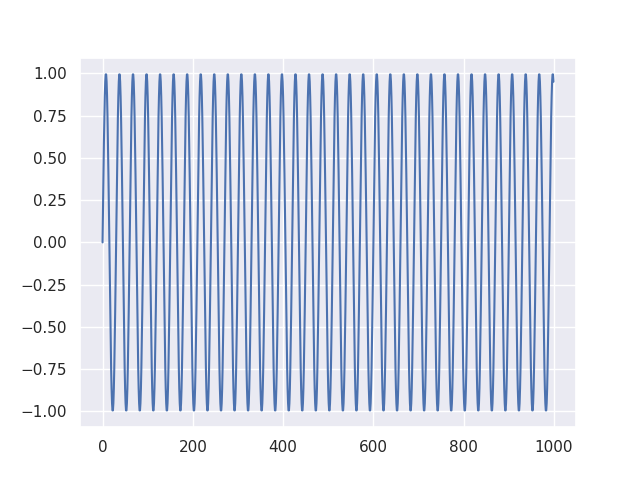

In [368]:
plt.figure()
plt.plot(f[-1000:,:])
plt.show()

In [369]:
### zeroth time step
#X_r = np.zeros((N))
#X_e = w_in @ u_in[0,:]
#X = alpha * w_in @ u_in[0,:]
X = np.random.normal(0.,1.,N)
y = np.tanh(X)

y_rec[0,:] = y
X_rec[0,:] = X
I_r_rec[0,:] = 0.
I_e_rec[0,:] = w_in @ u_in[0,:]

w_in_rec[0,:,:] = w_in 
w_out_rec[0,:,:] = w_out

u_out[0,:] = w_out @ y

err = u_out[0,:] - f[0,:]

err_rec[0] = 0.5*(err**2.).sum()

dxdw[:] = 0.
dxdw_in[:] = 0.
dxda[:] = 0.


for t in tqdm(range(1,T)):
    
    u_in[t,:] = 0.#u_out[t-1,:]
    
    I_r = W @ y
    I_e = w_in @ u_in[t,:]
    
    X = (1.-alpha)*X + alpha * (I_r + I_e)
    y_prev = y
    y = np.tanh(X)
    
    #X_r = a * (W @ y[1:])
    #X_e = w_in @ u_in[t,:]
    
    
    
    #y[1:] = np.tanh(X_r + X_e - b)
    
    u_out[t,:] = w_out @ y
    
    ### learning
    dxdw = (1.-alpha) * dxdw + alpha * y_prev
    #dxdw_in = (1.-alpha) * dxdw_in + alpha * u_in[t,:]
    #dxda = (1.-alpha) * dxda + alpha * I_r / a
    
    err = u_out[t,:] - f[t,:]
    
    w_out_T_err = w_out.T @ err
    
    delta_w_out = -eps_w_out * np.outer(err,y)
    #delta_a = -eps_a * w_out_T_err * (1.-y[1:]**2.) * dxda
    #delta_b = eps_b * w_out_T_err * (1.-y[1:]**2.)
    #delta_w_in = -eps_w_in * np.outer(w_out_T_err * (1.-y[1:]**2.),dxdw_in)
    delta_W = -eps_w * np.outer(w_out_T_err * (1.-y**2.),dxdw)
    
    w_out += delta_w_out
    #a += delta_a
    #b += delta_b
    #w_in += delta_w_in
    W += delta_W
    #W[range(N),range(N)] = 0.
    
    ###recording
    if t%T_skip_rec == 0:
        t_rec = int(t/T_skip_rec)
        
        y_rec[t_rec,:] = y
        X_rec[t_rec,:] = X
        I_r_rec[t_rec,:] = I_r
        I_e_rec[t_rec,:] = I_e

        w_in_rec[t_rec,:,:] = w_in 
        w_out_rec[t_rec,:,:] = w_out
        
        err_rec[t_rec] = 0.5*(err**2.).sum()

<IPython.core.display.Javascript object>


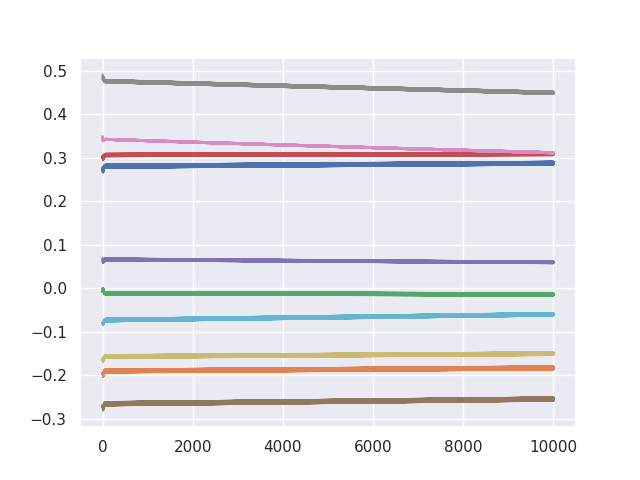

In [370]:
plt.figure()
plt.plot(w_out_rec[:,0,:10])
plt.show()

<IPython.core.display.Javascript object>


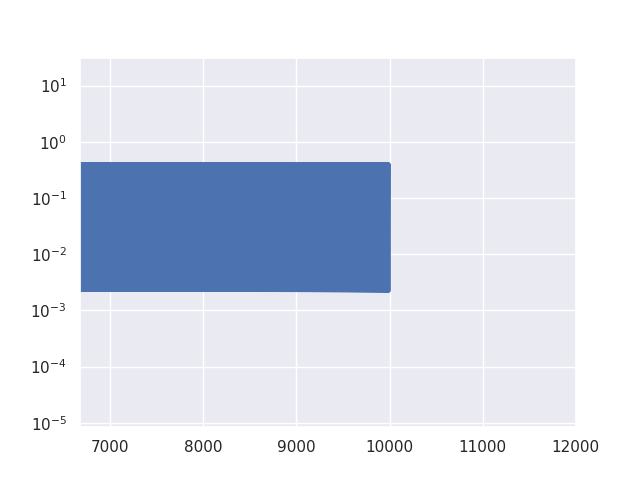

In [371]:
plt.figure()
plt.plot(err_rec)
plt.yscale("log")
plt.show()

<IPython.core.display.Javascript object>


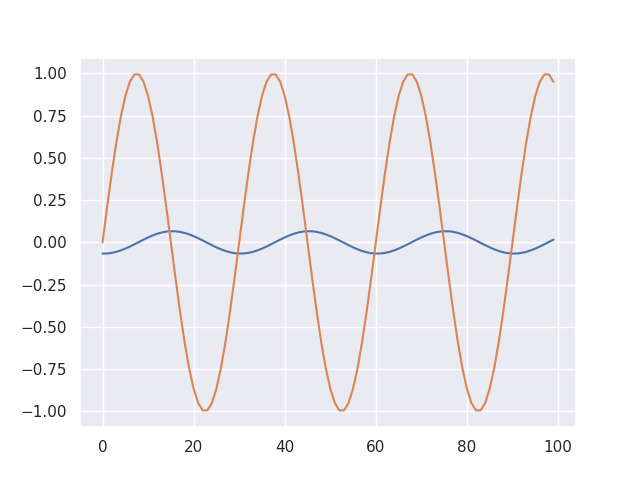

In [372]:
plt.figure()
plt.plot(u_out[-100:,:])
plt.plot(f[-100:,:])
plt.show()

<IPython.core.display.Javascript object>


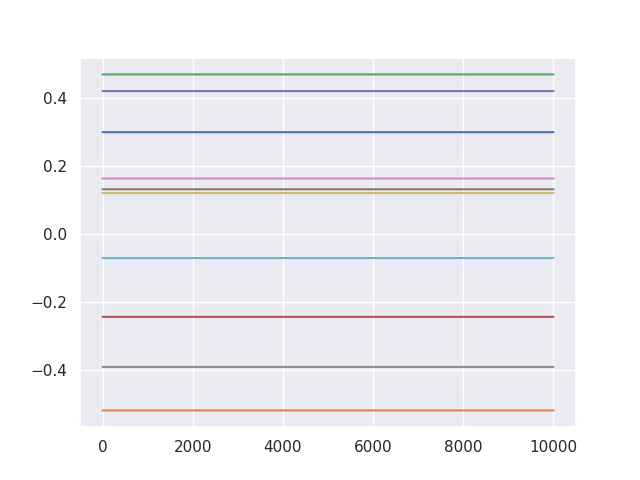

In [362]:
plt.figure()
plt.plot(w_in_rec[:,:10,0])
plt.show()

<IPython.core.display.Javascript object>


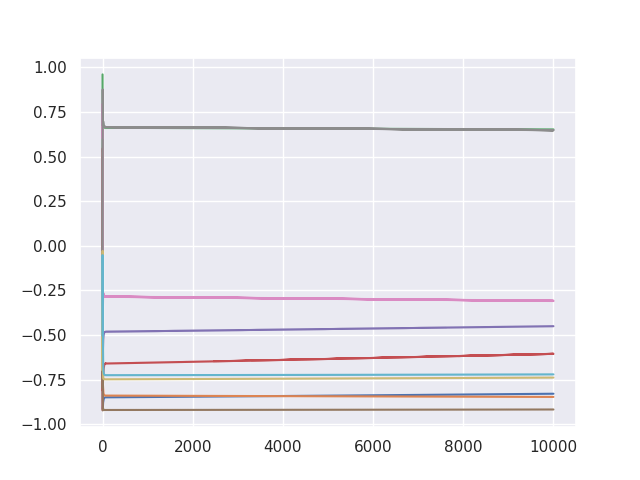

In [373]:
plt.figure()
plt.plot(y_rec[:,:10])
plt.show()